In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score # pour voir l'efficacité globale du modèle
from sklearn.metrics import recall_score # pour voir le poids des Faux negatifs
from sklearn.metrics import precision_score # pour voir le poids des faux positifs
from sklearn.metrics import f1_score # rapport de la moyenne géométrique au carré et de la moyenne aritmétique entre le recall et la précision
from sklearn.metrics import confusion_matrix


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import SparsePCA

from sklearn.preprocessing import StandardScaler

path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Apprentissage_Statistique_Panloup/TP2/donnees_en_point_csv'

os.listdir(path)

['cancer_ytest.csv',
 'cancer_ytrain.csv',
 'cancer_xtest.csv',
 'cancer_xtrain.csv']

In [2]:
cancer_ytest = pd.read_csv(os.path.join(path,'cancer_ytest.csv'), sep=',')
cancer_ytrain = pd.read_csv(os.path.join(path,'cancer_ytrain.csv'), sep=',')
cancer_xtest = pd.read_csv(os.path.join(path,'cancer_xtest.csv'), sep=',')
cancer_xtrain = pd.read_csv(os.path.join(path,'cancer_xtrain.csv'), sep=',')

# Première approche :

## Équilibrage des groupes :

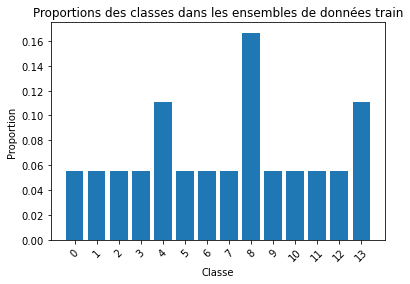

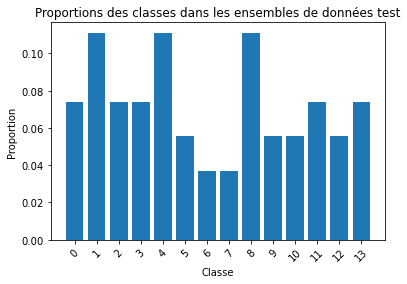

In [3]:
ytr = cancer_ytrain.value_counts()/len(cancer_ytrain) 
# value counts donne le nombre de valeurs différentes dans la colonne
yts = cancer_ytest.value_counts()/len(cancer_ytest)

indextr = [i[0] for i in ytr.index]
plt.bar(indextr,ytr.values)
plt.title('Proportions des classes dans les ensembles de données train')
plt.xlabel('Classe')
plt.ylabel('Proportion')
plt.xticks(range(len(indextr)), np.sort(indextr), rotation=45) # Ajouter plus de ticks sur l'axe des x
plt.show()

indexts = [i[0] for i in yts.index]
plt.bar(indexts,yts.values)
plt.title('Proportions des classes dans les ensembles de données test')
plt.xlabel('Classe')
plt.ylabel('Proportion')
plt.xticks(range(len(indexts)), np.sort(indexts), rotation=45)
plt.show()



Les groupe ne semblent pas équilibrés à la perfection, nous allons utiliser en plus de l'accuracy le F1-score comme métrique afin d'évaluer la performance de nos modèles. En effet il est plus riche que la précision simple, car il prend en compte à la fois la précision et le rappel.

Explications:

Precision : P = $\dfrac{TP}{TP+FP}$

Recall : R = $\dfrac{TP}{TP+FN}$

F1_score : F1 = $2\times\dfrac{P\times R}{P+R}$


Accuracy_score : Acc = $\dfrac{TP +TN}{TP+TN+FP+FN}$

<img src="TPTN.png" alt="Mon image" width="500" height="300">


## Fonctions utiles :



In [4]:
#Fonctions utiles à l'évaluation d'un modèle

def evaluation(model,xtrain,xtest,ytrain,ytest,average = 'weighted', tree = True, display=True):
    """Fonction qui permet d'évaluer un modèle de type arbre"""
    
    # Faire des prédictions
    predictions1 = model.predict(xtrain)
    predictions2 = model.predict(xtest)

    # Évaluer globale
    accuracy1 = accuracy_score(ytrain, predictions1)
    accuracy2 = accuracy_score(ytest, predictions2)

    print("evaluation globale train :", accuracy1)
    print("evaluation globale test:", accuracy2)

    # precision du modèle
    precision1 = precision_score(ytrain, predictions1, average=average)
    precision2 = precision_score(ytest, predictions2, average=average)

    print("precision train :", precision1)
    print("precision test :", precision2)

    # Recall du modèle
    recall1 = recall_score(ytrain, predictions1, average=average)
    recall2 = recall_score(ytest, predictions2, average=average)

    print("recall train :", recall1)
    print("recall test:", recall2)

    # F1 score du modèle
    f1_1 = f1_score(ytrain, predictions1, average=average)
    f1_2 = f1_score(ytest, predictions2, average=average)

    print("f1 score train :", f1_1)
    print("f1 score test:", f1_2)

    if display:
        # Calcul de la matrice de confusion
        conf_matrix = confusion_matrix(ytest, predictions2)

        # Création de la heatmap avec Seaborn
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='g',cmap='Blues') #fmt='g' sert à éviter l'affichage scientifique des nombres
        plt.xlabel('Prédictions')
        plt.ylabel('Valeurs Réelles')
        plt.title('Matrice de Confusion pour les valeurs tests')
        plt.show()

    if tree:
        # Affichage de l'arbre
        plt.figure(figsize=(20,10))
        plot_tree(model, filled=True) #filled=True colorant les noeuds pour indiquer la majorité de la classe.
        plt.title("Schéma de l'arbre")
        plt.show()

def features(model,xtrain,ytrain, display1=True,display2=True):
    """Pour certain modèle, il est possible de voir l'importance de chaque variables dans les prises de décisions"""
    
    #Avoir le nom des colonnes 
    features_names = xtrain.columns 
    #Récupérer l'importance des features
    features_importantes = model.feature_importances_
    #Trier les index par odre croissant en valeur puis les lire de droite à gauche 
    index = features_importantes.argsort()[::-1] 

    if display1:
        #Au dessus de 60 c'est illisible donc on cocidère deux cas
        if len(features_importantes[features_importantes!=0])<=60:
            y = np.sort(features_importantes[features_importantes!=0])[::-1]
            ind = index[:len(y)]
            plt.bar(range(len(y)),y)
            plt.xticks(range(len(ind)), ind, rotation='vertical') # Définir les étiquettes pour l'axe des x
            plt.tight_layout() # Ajuster le layout pour éviter le chevauchement des étiquettes            
        else:
            y = features_importantes[features_importantes!=0]
            ind = index[:len(y)]
            plt.bar(ind,y)
        
       
        plt.title(f"Importances des variables dans le {model}")
        plt.xlabel("Feature")
        plt.ylabel("Importance")
        plt.show()
        
    
    if display2:
        #Scatter plot des deux variables le plus importantes dans la discrimination
        f1 = features_names[index[0]]
        f2 = features_names[index[1]]

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(xtrain[f1], xtrain[f2], c=(ytrain.values+1)) # +1 car erreur si 0 
        plt.title(f'Scatter Plot des variables les plus importantes {f1} et {f2}')
        plt.xlabel(f"feature {f1}")
        plt.ylabel(f"feature {f2}")
        
        classes = np.unique(ytrain)
        labels = ['Classe ' + str(cls) for cls in classes]
        plt.legend(handles=scatter.legend_elements()[0], labels=labels)

        plt.show()
                

      

# Basic decisional Tree :

evaluation globale train : 1.0
evaluation globale test: 0.5370370370370371
precision train : 1.0
precision test : 0.5679012345679012
recall train : 1.0
recall test: 0.5370370370370371
f1 score train : 1.0
f1 score test: 0.535626102292769


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


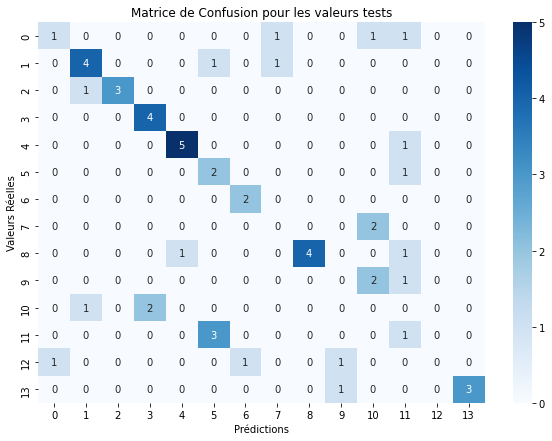

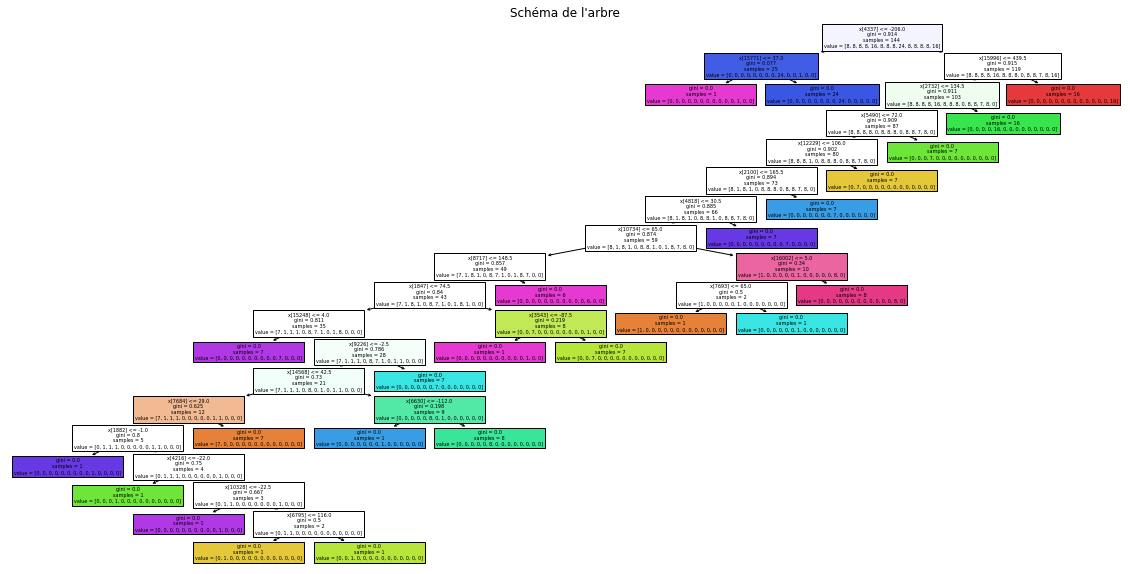

In [19]:
# Créer le modèle DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Entraîner le modèle
clf.fit(cancer_xtrain, cancer_ytrain)

evaluation(clf,cancer_xtrain,cancer_xtest,cancer_ytrain,cancer_ytest,tree = True, display=True)


Il est clair ici que le modèle est en sur-apprentissage, le score F1 de la partie train est de 100\% alors que celui de la partie test est de 52\%. Il y a un écart net, le modèle construit n'est pas capable de généraliser sur des nouvelles données.   

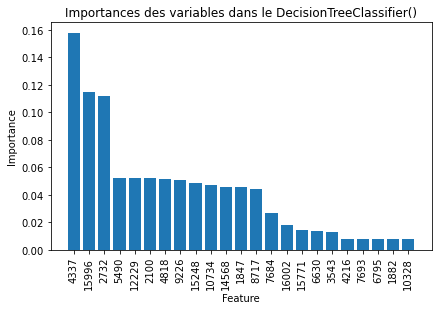

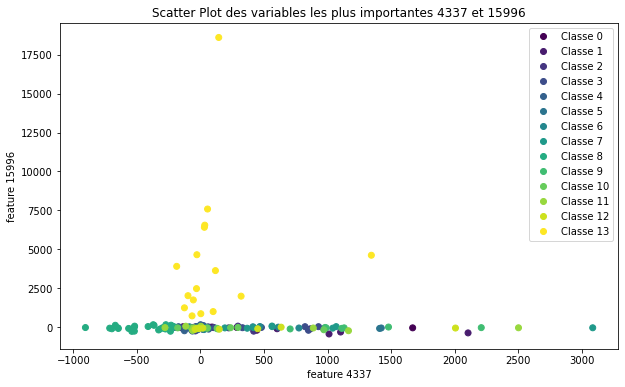

In [20]:
features(clf,cancer_xtrain,cancer_ytrain)


# Grid_Search CV

In [296]:

clf = DecisionTreeClassifier()

#dico avec les paramètres
param = { 'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.03] }

grid = GridSearchCV(clf,param,cv=5,scoring='f1_weighted', n_jobs=-1)#,verbose=2)

# n_jobs is used for parallemization , while verbose help you track the progres and duration of the process

grid.fit(cancer_xtrain,cancer_ytrain)

best_clf = grid.best_estimator_

best_params =  {'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2} 


evaluation globale train : 0.9791666666666666
evaluation globale test: 0.4444444444444444
precision train : 0.9814814814814814
precision test : 0.48858024691358026
recall train : 0.9791666666666666
recall test: 0.4444444444444444
f1 score train : 0.9790849673202615
f1 score test: 0.45631981187536746


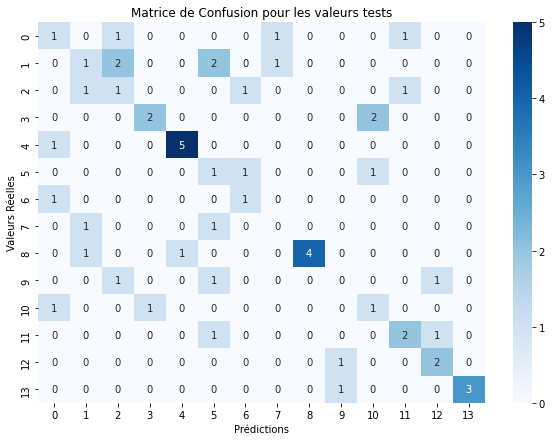

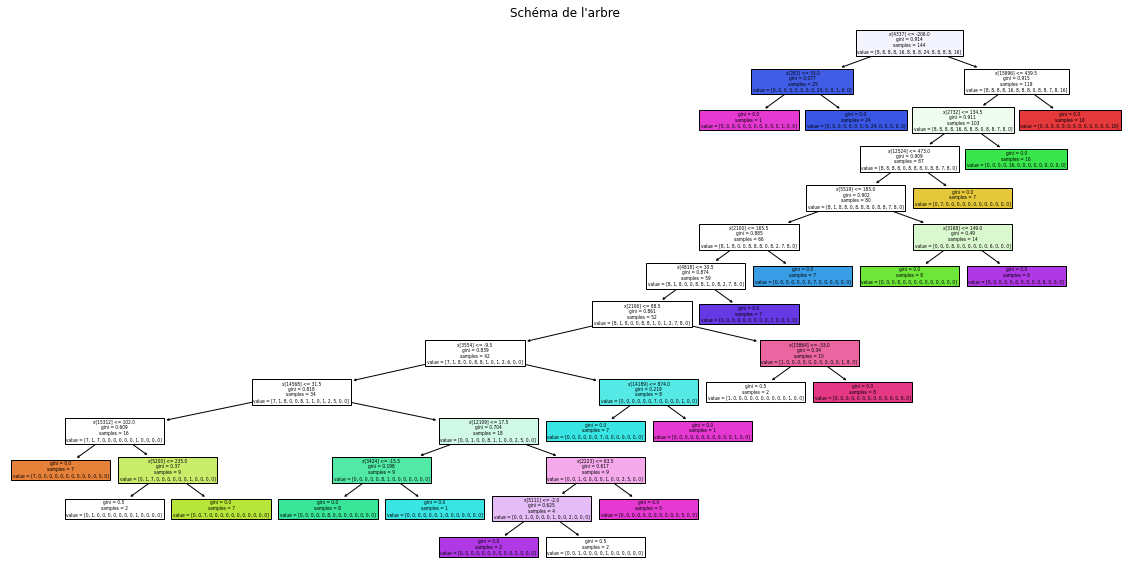

In [297]:
print("best_params = ",grid.best_params_,"\n\n")
evaluation(best_clf,cancer_xtrain,cancer_xtest,cancer_ytrain,cancer_ytest,tree = True, display=True)

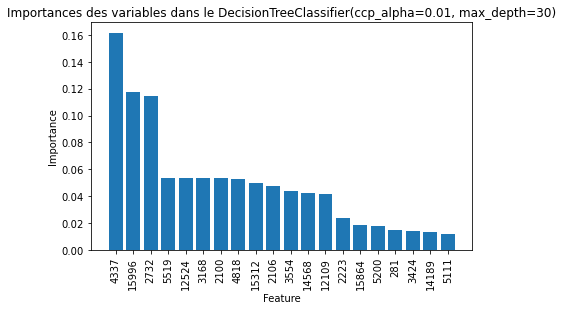

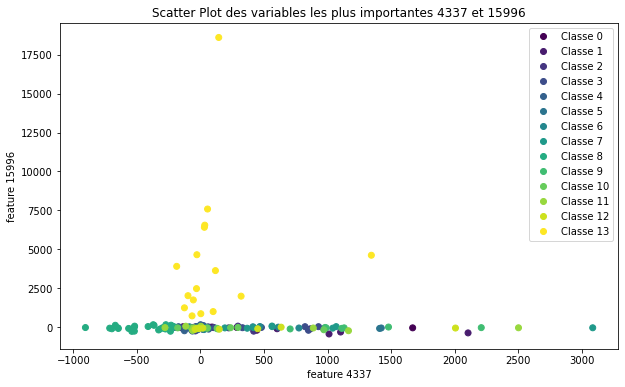

In [298]:
features(best_clf,cancer_xtrain,cancer_ytrain)

Les scores sur l'échantillon test avec la méthode Grid search cv ne sont pas bons. Nous allons donc proposer d'autres axes de recherche tels que du Bootstrap avec du bagging, de la random forest ou encore du boosting. 

# Bagging

evaluation globale train : 1.0
evaluation globale test: 0.6296296296296297
precision train : 1.0
precision test : 0.6753086419753087
recall train : 1.0
recall test: 0.6296296296296297
f1 score train : 1.0
f1 score test: 0.6236572069905404


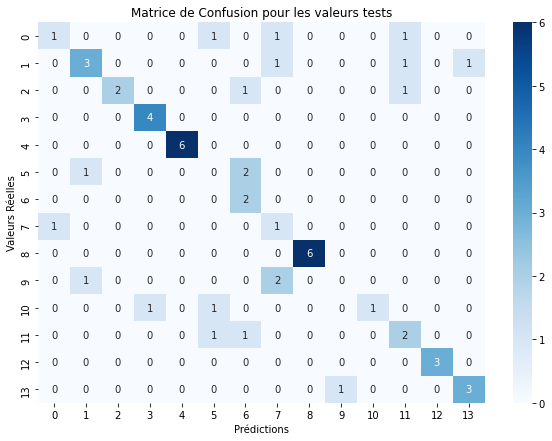

In [299]:
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators = 100, max_features=0.8)

# Entraînement du modèle
bagging_clf.fit(cancer_xtrain,cancer_ytrain.values.ravel())

evaluation(bagging_clf,cancer_xtrain,cancer_xtest,cancer_ytrain,cancer_ytest,tree = False, display=True)

* L'argument max_features=0.8 nous permet de choisir aléatoirement 80% des variables à l'initialisation de chaque arbre dans le bootstrap. Cela ressemble à de la Random Forest car il y a une part d'aléatoire dans le choix des variables. Ce qui différencie de la Random Forest est que le choix est fixé au début de chaque arbre et non à chaque noeud de chaque arbre comme le fait la Random Forest.  

* Le Bagging ne nous permet pas d'obtenir de meilleurs résultats. Nous soupçonnons qu'il y a une très forte corrélation entre certaines variables et aussi un nombre important de variables non explicatives. 

# Random Forest

## Approche sans grid_cv

evaluation globale train : 1.0
evaluation globale test: 0.5925925925925926
precision train : 1.0
precision test : 0.592636684303351
recall train : 1.0
recall test: 0.5925925925925926
f1 score train : 1.0
f1 score test: 0.5675070813959702


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


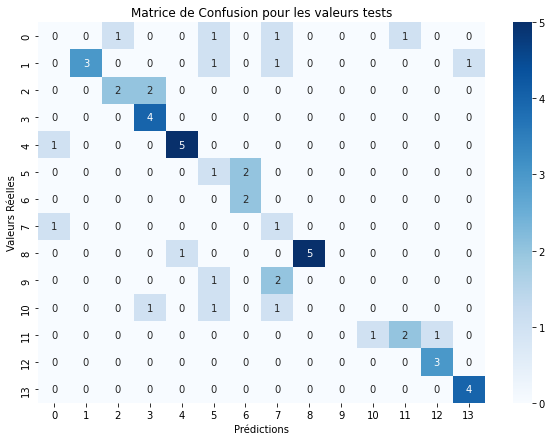

In [301]:
# Créer et entraîner le modèle Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(cancer_xtrain, cancer_ytrain.values.ravel())

evaluation(clf_rf,cancer_xtrain,cancer_xtest,cancer_ytrain,cancer_ytest,tree = False, display=True)



In [302]:
print(clf_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


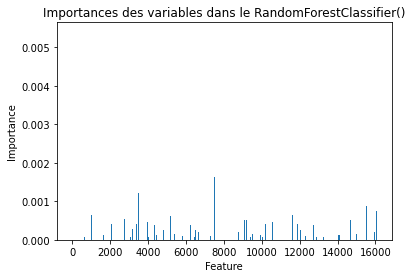

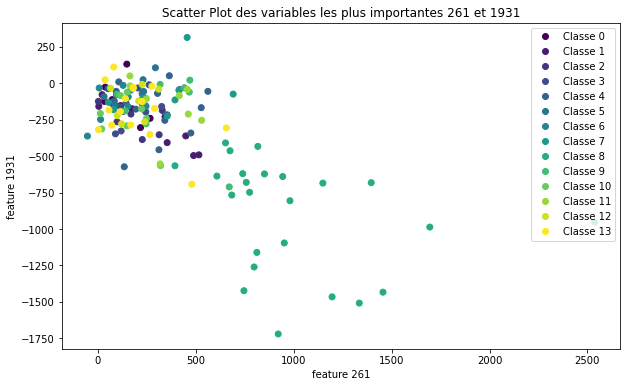

In [303]:
features(clf_rf,cancer_xtrain,cancer_ytrain)


## Grid search CV

In [304]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf_rf = RandomForestClassifier()

# Création du modèle GridSearchCV
grid_search = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=5, n_jobs=-1)#, verbose=2)
grid_search.fit(cancer_xtrain, cancer_ytrain.values.ravel())

# Meilleur modèle
clf_rf_best= grid_search.best_estimator_

evaluation globale train : 0.9930555555555556
evaluation globale test: 0.6111111111111112
precision train : 0.9938271604938271
precision test : 0.5924603174603175
recall train : 0.9930555555555556
recall test: 0.6111111111111112
f1 score train : 0.9930283224400872
f1 score test: 0.5761197650086538


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


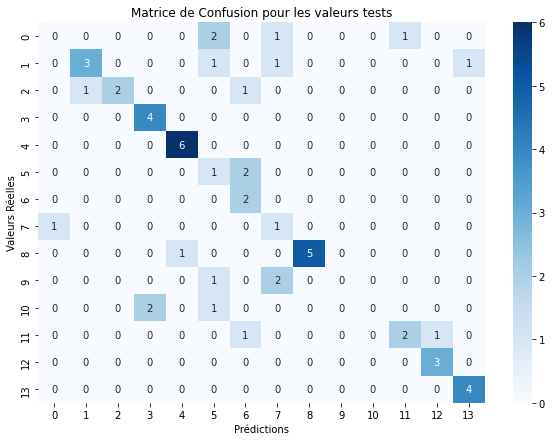

In [305]:
evaluation(clf_rf_best,cancer_xtrain,cancer_xtest,cancer_ytrain.values.ravel(),cancer_ytest.values.ravel(),tree = False, display=True)

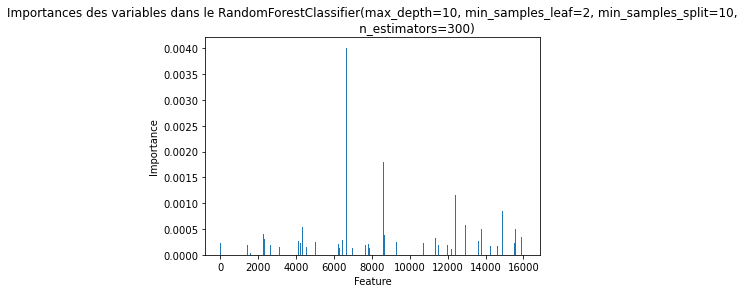

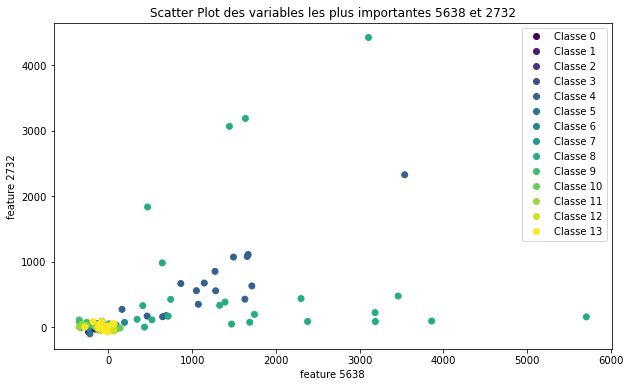

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [306]:
features(clf_rf_best,cancer_xtrain,cancer_ytrain)
print(clf_rf_best.get_params())

# Gradient Boosting

In [308]:
# Création du modèle Gradient Boosting
clf_gb = GradientBoostingClassifier()
clf_gb.fit(cancer_xtrain,cancer_ytrain.values.ravel())


GradientBoostingClassifier()

Paramètres du modèle Gradient Boosting :
 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

evaluation globale train : 1.0
evaluation globale test: 0.6111111111111112
precision train : 1.0
precision test : 0.585232668566002
recall train : 1.0
recall test: 0.6111111111111112
f1 score train : 1.0
f1 score test: 0.5757162969151273


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


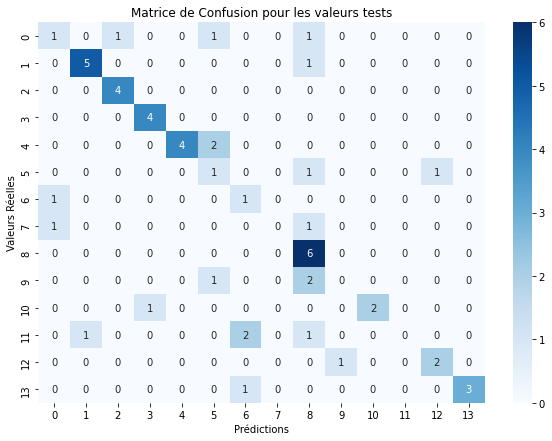

In [312]:
# Affichage des paramètres du modèle
print("Paramètres du modèle Gradient Boosting :\n", clf_gb.get_params(),"\n")

evaluation(clf_gb,cancer_xtrain,cancer_xtest,cancer_ytrain.values.ravel(),cancer_ytest.values.ravel(),tree = False, display=True)


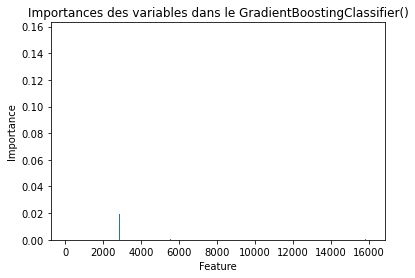

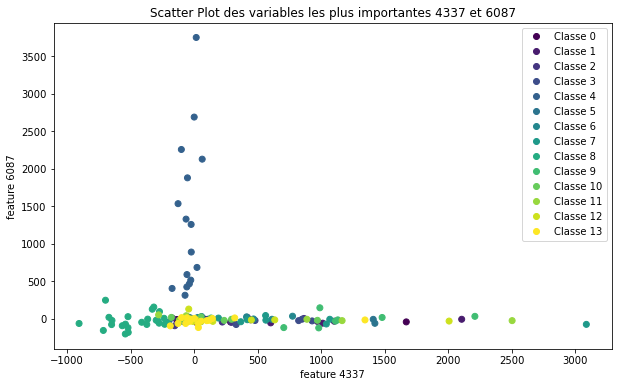

In [314]:
features(clf_gb,cancer_xtrain,cancer_ytrain)

## Bilan 

Dans cette première partie, nous avons des difficultés à trouver un bon modèle de machine learning en rapport avec les arbres de décisions pour les données fournies initialement. Nous pourrions normaliser les données et nous allons  modifier celles-ci à l'aide de méthodes de réduction de dimensions type ACP, LDA, Sparce ACP.  

# Traitement des données et modèles. 

## Normalisation + ACP + Random Forest


In [7]:
scaler = StandardScaler()
scaler.fit(cancer_xtrain) # construire un normalisateur avec les données train

X_train = scaler.transform(cancer_xtrain) #Pour standardiser les données train 
X_test = scaler.transform(cancer_xtest) # on standardise les données avec le normalisateur train

pca = PCA(n_components=0.95)
pca.fit(X_train)


PCA(n_components=0.95)

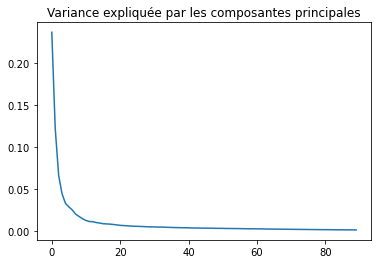

In [8]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Variance expliquée par les composantes principales")
plt.show()

evaluation globale train : 1.0
evaluation globale test: 0.5740740740740741
precision train : 1.0
precision test : 0.5786008230452675
recall train : 1.0
recall test: 0.5740740740740741
f1 score train : 1.0
f1 score test: 0.5162149578816244


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


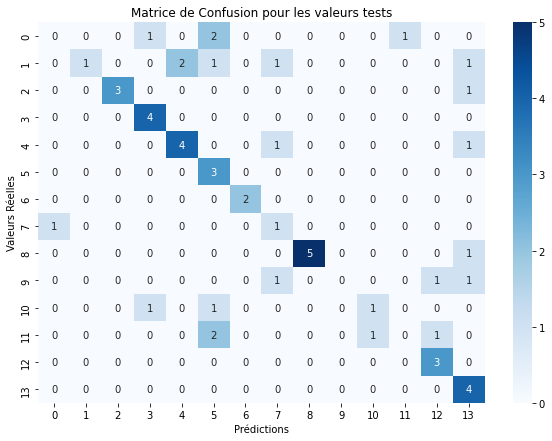

In [9]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Créer et entraîner le modèle Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_pca, cancer_ytrain.values.ravel())

evaluation(clf_rf,X_train_pca,X_test_pca,cancer_ytrain,cancer_ytest,tree = False, display=True)




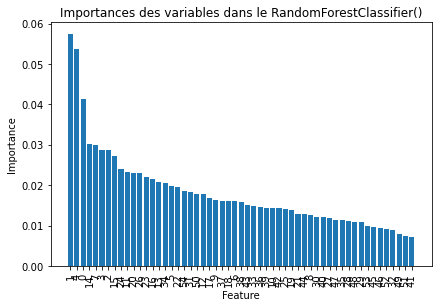

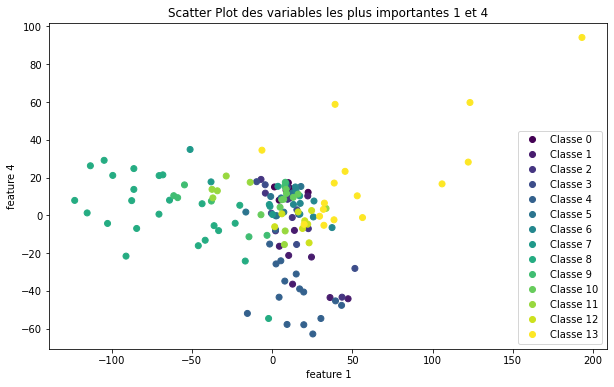

In [318]:
features(clf_rf,pd.DataFrame(X_train_pca),cancer_ytrain)


## Normalisation + LDA + Random Forest

L'objectif principal de LDA est de trouver une combinaison linéaire des caractéristiques d'un ensemble de données de manière à maximiser la séparation entre différentes classes de données tout en minimisant la variance intra-classe.

In [11]:
# Réduction de dimension avec LDA
lda = LDA(n_components=10)
X_train_lda = lda.fit_transform(X_train, cancer_ytrain.values.ravel())
X_test_lda = lda.transform(X_test)

evaluation globale train : 1.0
evaluation globale test: 0.5185185185185185
precision train : 1.0
precision test : 0.5912992357436802
recall train : 1.0
recall test: 0.5185185185185185
f1 score train : 1.0
f1 score test: 0.48937502826391716


/home/ibotcazou/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


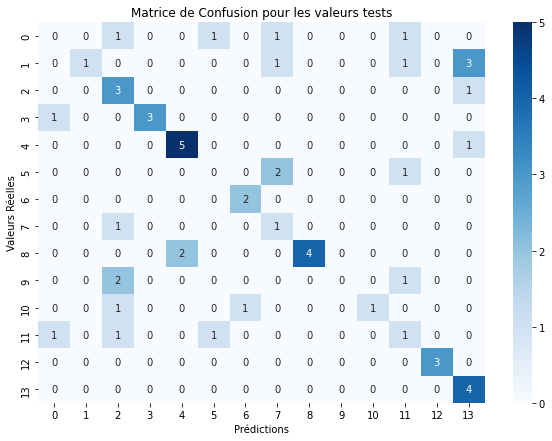

In [12]:
# Créer et entraîner le modèle Random Forest

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_lda, cancer_ytrain.values.ravel())

evaluation(clf_rf,X_train_lda,X_test_lda,cancer_ytrain,cancer_ytest,tree = False, display=True)



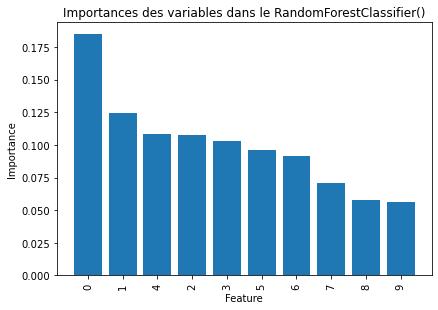

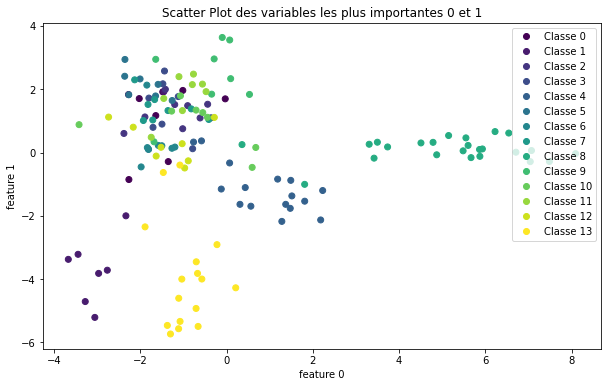

In [13]:
features(clf_rf,pd.DataFrame(X_train_lda),cancer_ytrain)
